In [18]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.preprocessing import imputation

from tqdm import tqdm
import gc
from numba import jit
from matplotlib import pyplot as plt
from scipy.stats import spearmanr
from scipy.stats import mannwhitneyu
from scipy.stats import wasserstein_distance as w1_dist
from scipy.stats import energy_distance as w2_dist
from scipy.special import kl_div
from collections import namedtuple
from time import time

from joblib import Parallel, delayed
import multiprocessing

In [2]:
def _clean(x, default='float'):   
    # TO-DO add outlier removal...
    non_default = 'int' if default=='float' else 'float'
    try:
        x.replace([np.inf, -np.inf], np.nan, inplace=True)
        x.dropna(how='all', axis=1, inplace=True)
        if default=='float':
            x = x * 1.0
        else:
            x = x * 1
    except Exception as e:
        print(e)
        for col in x.columns:
            if 'object' in str(x[col].dtypes):
                try:
                    x[col] = x[col].astype(default)
                except:
                    try:
                        x[col] = x[col].astype(non_default)
                    except:
                        print(col)
                        x[col] = x[col].astype('category')
    return x

def get_transposed(df, NameRow='GenX', prefix='GenX'):
    transposed  = df.T
    new_index = transposed.loc[[NameRow]].values.tolist()[0]
    transposed.columns = new_index
    if prefix is not None:
        transposed.columns = [prefix+'_'+_col for _col in transposed.columns.values.tolist()]
    return transposed.drop(NameRow, axis=0, inplace=False)

# def _impute(df, type='FM):
#   # use similarity to replace missing values with values for most similar patients.

from sklearn.ensemble import IsolationForest
def _remove_outliers(x, method='isoforest'):
    '''
    x: pandas data frame or numpy array
    method: isoforest 
    '''
    # consider Angle Based Outlier Detection
    # consider using sample aggregate of z-scores
    
    if method=='isoforest': 
        # isolation forest       
        model = IsolationForest(n_estimators=100,)
        return x[np.where(model.fit_predict(x)==-1)]
          
    
def _distance_significance(x,y, method='MWU'):
    # difference between distributions
    #
    # consider 1st (EMD) and 2nd (Cramer Von Mises) Wasserstein distance --> equal to area between CDF's for 1D distro's
    # consider Kolmogorov-Smirnov
    # consider MW-U
    # consider modified z-scores
    # consider quantiles
    # consider Kruskal Wallis
    # diff per feature, per sample -> expensive
    # scipy.stats import wasserstein_distance
    # scipy.stats import energy_distance
    # Kullback-Leibler divergence, Jensen-Shannon divergence, etc. only works for coupled data
    # Spearman-Rank, Cosine-distance, etc. only works for coupled data or data of the same size.
    
    return True

    
                     
def _outliers_modified_z_score(ys, threshold = 3.5):
    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return modified_z_scores, np.where(np.abs(modified_z_scores) > threshold)
    

In [3]:
def timeit(method):
    def timed(*args, **kw):
        ts = time()
        result = method(*args, **kw)
        te = time()

        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result

    return timed

@timeit
def _qn(x, agg='mean'):
    # assumes column-wise normalisation
    x_sorted = np.empty(x.shape, dtype='float16')
    x_arg_sorted = np.empty(x.shape, dtype='int64')
    x_agg = np.empty(x.shape, dtype='float16')
    x_res = np.empty(x.shape, dtype='float16')
    
    if agg=='mean':
        @jit
        def _agg(x):
            return np.nanmean(x)
    elif agg=='median':
        @jit
        def _agg(x):
            return np.nanmedian(x)
    
    print('Sorting probe vectors..')
    for j in range(0, x.shape[1]):
        x_sorted[:,j] = np.sort(x[:, j])
        x_arg_sorted[:,j] = np.argsort(x[:, j])
    print('Extract agg values per rank..')
    for i in range(0, x.shape[0]):
        x_agg[i,:] = _agg(x_sorted[i,:])
    print('attach agg values to original rank vectors and unsort')
    for j in range(0, x.shape[1]):
        iv = x_arg_sorted[:,j].astype(int)
        x_res[:,j] = x_agg[:,j][iv]
          
    return x_res


In [4]:
pheno_small = pd.read_csv("../_docs/Lung_Phenotype_Metadata.txt", sep="\t")
pheno_large = pd.read_csv("../_docs/Lung_Table_Phenotypes.txt", sep="\t")
pheno_large.set_index('submitter_id.samples', inplace=True)

In [13]:
sourceDir = "/media/koekiemonster/DATA-FAST/genetic_expression/hackathon_2/" # "/media/bramvanes/Extra/DATA/RexR/2018" #  #"/media/bramvanes/Extra/DATA/RexR/2018" #
gene_expression = pd.read_table(sourceDir+"/Lung/Lung_GeneExpression.txt", sep="\t")

In [14]:
affx_labels = list(gene_expression.set_index('Gene').filter(axis=0, regex=r"^(AFFX.*)").index) # AFFX 
gene_expression = gene_expression.drop(affx_labels, axis=0)

gene_expression = gene_expression[np.isfinite(gene_expression.Start)]
gene_expression = gene_expression[np.isfinite(gene_expression.Stop)]

gene_expression.Start = gene_expression.Start.astype(int).astype(str)
gene_expression.Stop = gene_expression.Stop.astype(int).astype(str)
gene_expression.Chr = gene_expression.Chr.astype(str)
gene_expression.Gene = gene_expression.Gene.astype(str)

gene_expression['GenX'] = gene_expression[['Gene', 'Chr', 'Start', 'Stop', 'Strand']].apply(lambda x: '.'.join(x), axis=1)
gene_expression = gene_expression.copy().loc[~gene_expression.GenX.duplicated(keep='first')]
_map_RNA = gene_expression[['Gene', 'Chr', 'Start', 'Stop', 'Strand', 'GenX']]

gene_expression = gene_expression.drop(['Gene', 'Chr', 'Start', 'Stop', 'Strand'], axis=1)

# remove duplicate GenX values


RNA_cleaned_transposed =  _clean(get_transposed(gene_expression))

In [ ]:
# CLEAN MEMORY
del gene_expression
gc.collect()

In [15]:
# merge with phenotypes
pheno_features = ['batch_number', 'code.tissue_source_site', 'sample_type.samples', 'vial_number', 'ethnicity.demographic', 'gender.demographic',
                   'race.demographic', 'year_of_birth.demographic', 'diagnosis']

In [16]:
merged_RNA = RNA_cleaned_transposed.merge(pheno_large[pheno_features], how='left', left_index=True, right_index=True)


In [17]:
# There are patients with multiple measurements, we simply take the mean 
gene_columns = [_col for _col in merged_RNA.columns if 'GenX' in _col]
other_columns = [_col for _col in merged_RNA.columns if 'GenX' not in _col]

merged_RNA['patient_nr'] = merged_RNA.index
tmp_min = merged_RNA[['patient_nr']+gene_columns].groupby(by='patient_nr').mean()
merged_RNA = merged_RNA.copy()[other_columns].merge(tmp_min, how='right', left_index=True, right_on='patient_nr')
merged_RNA = merged_RNA.loc[~merged_RNA.index.duplicated(keep='first')]

# Bias correction functions

## L/S, cohort-based normalisation

Mean-based $$\mathbf{x}^*=\frac{\mathbf{x}-\overline{\mathbf{x}}}{\sigma}$$


Median-based $$\mathbf{x}^*=\frac{\mathbf{x}-median(\mathbf{x})}{IQR}$$

Minmax-based $$\mathbf{x}^*=\frac{\mathbf{x} - min(\mathbf{x})}{max(\mathbf{x}) - min(\mathbf{x})}$$

## Quantile normalisation per cohort


The algorithm to obtain the vector of QN-values $F$ is as follows:
```
    1. per sample i we have N different probe values, in a vector v_i 
    2. for each vector v_i we determine the highest to the lowest values, i.e we sort the vectors
    3. now, per group of samples (or over all samples) we take the mean or the median of the values for each rank
    4. then we map these mean/median rank values to the original rank vectors 
```

In [168]:
# L/S parallelised
@timeit
def _preprocess_par(df, cohorts = [], 
                scaler = "standard", 
                bias_removal = False, 
                col_range = None, 
                min_cohort_size=10, 
                qrange=(0.25,0.75),
                debug=False,
                n_jobs=10,
                imputer=None):
        
        def _norm(cohort):
            ch = df['batch_number']==cohort
            if sum(ch)<min_cohort_size:
                print("Skipping cohort {}, because of low sample count: {}".format(cohort, sum(ch)))
            else:
                if debug==False:
                    try:
                        if imputer is not None:                                
                            imp = imputation.Imputer(strategy=imputer, axis=0)
                            res = scaler.fit_transform(imp.fit_transform(df.loc[ch,gene_columns].values))
                        else:
                            res = scaler.fit_transform(df.loc[ch,gene_columns].values)
                        df.loc[ch,gene_columns] = pd.DataFrame(data=res, index=ch[ch].index, columns=gene_columns)
                        print("Corrected cohort {}, with {} samples".format(cohort, sum(ch))) 
                    except Exception as e:
                        print("ERROR", e, "cohort:"+cohort)
                        print("index:",ch)
                        print("target:", df.loc[ch,gene_columns].shape) 
                        print("replacement:", res.shape)
                else:
                    for _col in gene_columns: # for debugging
                        df_temp = df.loc[ch, _col].copy() 
                        try:
                            df.loc[ch, _col] = (df_temp-df_temp.mean())/df_temp.std()
                        except Exception as e:
                            print("ERROR", e, "gene:"+_col, "cohort:"+cohort)
            return df[ch]
        def _quantile(cohort):
                ch = df['batch_number']==cohort
                tor = df.loc[ch, gene_columns]
                t = tor.T
                tqn = _qn(t.values)
                df[gene_columns][ch] = tqn.T # pd.DataFrame(data=tqn.T, index=tor.index, columns=gene_columns)
                return df[ch]
    
        if col_range is None:
            gene_columns = [_col for _col in df.columns if 'GenX' in _col]  
        else:                      
            cr = range(col_range[0], col_range[1])
            gene_columns = df.columns[cr]
        
        if len(cohorts)==0:
            cohorts = df.batch_number.unique().tolist()
        
        if scaler == "standard":
            scaler = preprocessing.StandardScaler(with_mean=True, with_std=True)
        elif scaler == "minmax":
            scaler = preprocessing.MinMaxScaler()
        elif scaler == "maxabs":
            scaler = preprocessing.MaxAbsScaler()
        elif scaler == "robust":
            scaler = preprocessing.RobustScaler(quantile_range=qrange, 
                                                    with_scaling=True, with_centering=True)
        elif scaler in ["normalizer", "normaliser"]:
            scaler = preprocessing.Normalizer()  
            
        if bias_removal == True:  
            print("- "*30, 'Removing cohort biases')    
            if scaler != 'quantile':           
                results = Parallel(n_jobs=n_jobs)(delayed(_norm)(cohort) for cohort in cohorts)
            else:
                results = Parallel(n_jobs=n_jobs)(delayed(_quantile)(cohort) for cohort in cohorts)
                
            print("- "*30, 'Concatenating results')    
            df = pd.concat(results)
            
        else:
            ch = df["batch_number"].isin(cohorts)
            df.loc[ch,gene_columns] = scaler.fit_transform(df.loc[ch,gene_columns])
            
        #df = df[df.batch_number.isin(cohorts)]
        return df  
    

In [169]:
# L/S correction
mean_shift=False
scaler = 'quantile'
qrange=(0.25,0.75)
merged_RNA_CBC_LS = _preprocess_par(merged_RNA.copy(), 
                                     col_range=None, 
                                     bias_removal=True, 
                                     debug=False, 
                                     scaler=scaler,
                                     qrange=qrange,
                                     min_cohort_size=14,
                                     n_jobs=16)

gc.collect()

gene_columns = [_col for _col in merged_RNA.columns if 'GenX' in _col]


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Removing cohort biases
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  Concatenating results
'_preprocess_par'  61253.78 ms


In [84]:
if mean_shift and scaler=='standard':
    # shifted back by overall mean/std
    merged_RNA_CBC_LS.loc[:, gene_columns] *= merged_RNA.loc[:, gene_columns].std(axis=0)
    merged_RNA_CBC_LS.loc[:, gene_columns] += merged_RNA.loc[:, gene_columns].mean(axis=0)
elif mean_shift and scaler=='minmax':    
    merged_RNA_CBC_LS.loc[:, gene_columns] *= (merged_RNA.loc[:, gene_columns].max(axis=0)
                                               -merged_RNA.loc[:, gene_columns].min(axis=0))
    merged_RNA_CBC_LS.loc[:, gene_columns] += merged_RNA.loc[:, gene_columns].min(axis=0)
elif mean_shift and scaler=='robust':
    merged_RNA_CBC_LS.loc[:, gene_columns] *= (merged_RNA.loc[:, gene_columns].quantile(q=qrange[1],axis=0)
                                               -merged_RNA.loc[:, gene_columns].quantile(q=qrange[0],axis=0))
    merged_RNA_CBC_LS.loc[:, gene_columns] += merged_RNA.loc[:, gene_columns].median(axis=0)    

Text(0.5,1,'Cohort comparison for GenX_TNMD.chrX.100584802.100599885 (+ strand) without scaling')

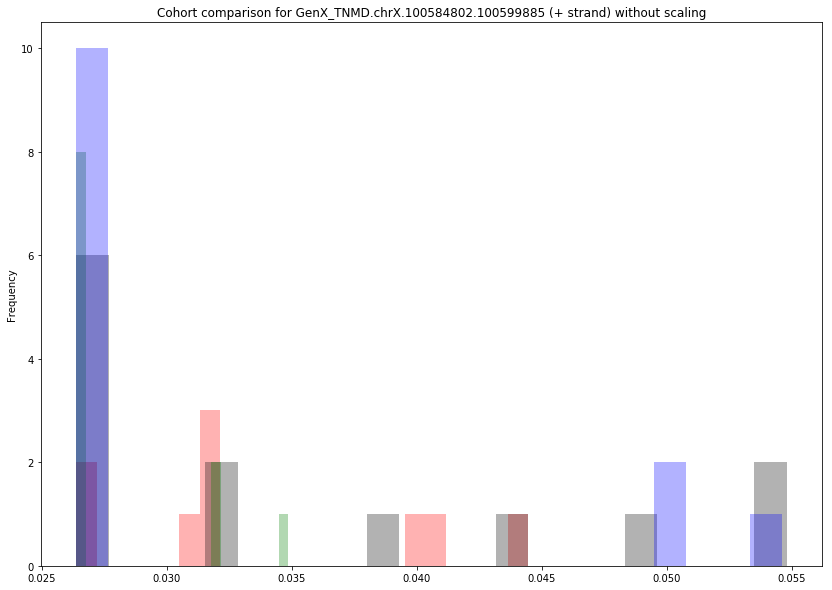

In [67]:
test_gene = 'GenX_TNMD.chrX.100584802.100599885'
merged_RNA.loc[merged_RNA.batch_number=='208.52.0'][test_gene]\
                .plot.hist(alpha=0.3, bins=22, figsize=(14,10), color='red')
merged_RNA.loc[merged_RNA.batch_number=='53.65.0'][test_gene]\
                .plot.hist(alpha=0.3, bins=22, figsize=(14,10), color='black')
merged_RNA.loc[merged_RNA.batch_number=='415.35.0'][test_gene]\
                .plot.hist(alpha=0.3, bins=22, figsize=(14,10), color='green')
merged_RNA.loc[merged_RNA.batch_number=='259.43.0'][test_gene]\
                .plot.hist(alpha=0.3, bins=22, figsize=(14,10), color='blue')
plt.title('Cohort comparison without scaling'.format(test_gene))

Text(0.5,1,'Cohort comparison without scaling')

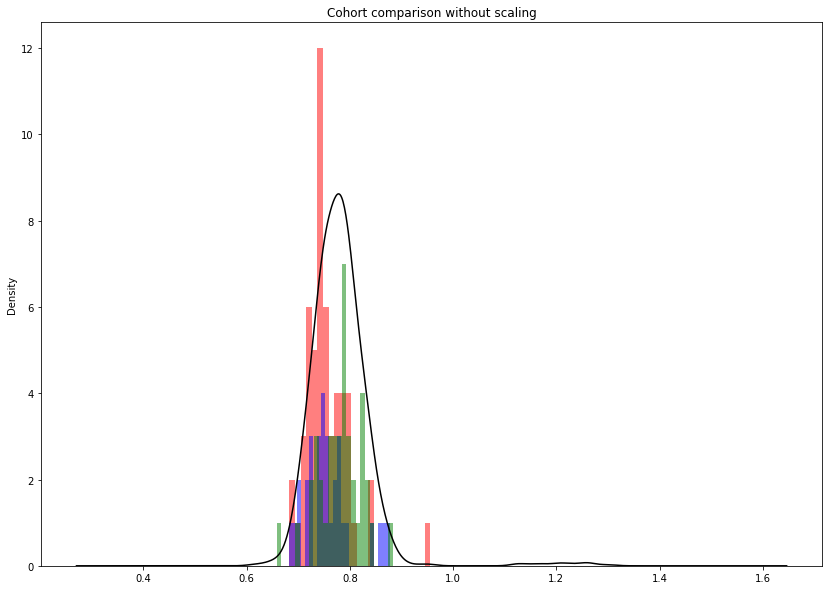

In [49]:
merged_RNA.loc[merged_RNA.batch_number=='119.75.0', gene_columns].mean(axis=1)\
                .plot.hist(alpha=0.5, bins=25, figsize=(14,10), color='red')
merged_RNA.loc[merged_RNA.batch_number=='84.72.0', gene_columns].mean(axis=1)\
                .plot.hist(alpha=0.5, bins=25, figsize=(14,10), color='blue')
merged_RNA.loc[merged_RNA.batch_number=='214.48.0', gene_columns].mean(axis=1)\
                .plot.hist(alpha=0.5, bins=25, figsize=(14,10), color='green')
merged_RNA.loc[:,gene_columns].mean(axis=1)\
                .plot.kde(color='black')
plt.title('Cohort comparison without scaling')

Text(0.5,1,'Cohort comparison using quantile normalisation')

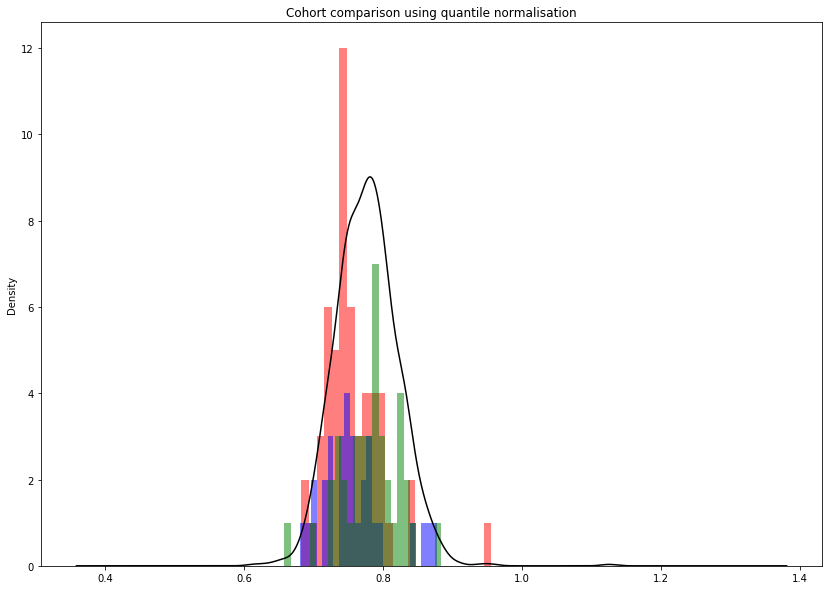

In [171]:
merged_RNA_CBC_LS.loc[merged_RNA_CBC_LS.batch_number=='119.75.0', gene_columns].mean(axis=1)\
                .plot.hist(alpha=0.5, bins=25, figsize=(14,10), color='red')
merged_RNA_CBC_LS.loc[merged_RNA_CBC_LS.batch_number=='84.72.0', gene_columns].mean(axis=1)\
                .plot.hist(alpha=0.5, bins=25, figsize=(14,10), color='blue')
merged_RNA_CBC_LS.loc[merged_RNA_CBC_LS.batch_number=='214.48.0',gene_columns].mean(axis=1)\
                .plot.hist(alpha=0.5, bins=25, figsize=(14,10), color='green')
merged_RNA_CBC_LS.loc[:,gene_columns].mean(axis=1)\
                .plot.kde(color='black')
plt.title('Cohort comparison using quantile normalisation')

In [172]:
merged_RNA_CBC_LS.to_csv(sourceDir+"/Lung/_prepped/RNAexpression_LSquantile.csv.gzip",compression="gzip")

In [ ]:
_map_RNA = _map_RNA.copy().loc[~_map_RNA.GenX.duplicated(keep='first')]
_map_RNA.to_csv(sourceDir+"/Lung/_prepped/map_GenX.csv.gzip", compression="gzip")

The biggest and most obvious downside of L/S normalisation, both with standard and with robust scaling, is the 
exaggeration of extremities in case of high kurtosis. 

The most drastic measure is to use quantile normalisation per cohort.

# Cohort bias detection

a-priori and a-posteriori


In [14]:
import rpy2.robjects as robjects
import numpy as np
from rpy2.robjects.packages import importr
preprocessCore = importr('preprocessCore')


In [87]:
def _dim_reduction(df, min_samples=10, n_comp=50, method='PCA', pc_solver='arpack'):
    # method: PCA
    gene_columns = [_col for _col in df.columns if 'GenX' in _col]
    cohorts = df.batch_number.unique().tolist()
    red_data_dict = {}
    for _cohort in tqdm(cohorts):
        ch = df['batch_number']==_cohort
        X = df.loc[ch, gene_columns]
        if X.shape[0]>min_samples:
            # PCA 3
            reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver=pc_solver)
            # put components in a dictionary with cohort as key
            X_red = reducer.fit_transform(X)
            #
            red_data_dict[_cohort] = {}
            red_data_dict[_cohort]['data'] = X_red
            red_data_dict[_cohort]['reducer'] = reducer
    print("Running reducer on all samples..")
    reducer = decomposition.PCA(copy=True, n_components=n_comp, svd_solver=pc_solver)
    X = df.loc[:, gene_columns]
    X_red = reducer.fit_transform(X)
    red_data_dict['ALL'] = {}
    red_data_dict['ALL']['data'] = X_red
    red_data_dict['ALL']['reducer'] = reducer
    
    
    return red_data_dict

In [174]:
# n_comp has to be equal to the minimum-batch size in rows :).
merged_RNA_PCA = _dim_reduction(merged_RNA, n_comp=8, min_samples=8, pc_solver='full')
merged_RNA_LS_PCA = _dim_reduction(merged_RNA_CBC_LS, n_comp=8, min_samples=8, pc_solver='full')

100%|██████████| 43/43 [00:09<00:00,  5.27it/s]


Running reducer on all samples..


100%|██████████| 42/42 [00:08<00:00,  5.92it/s]


Running reducer on all samples..


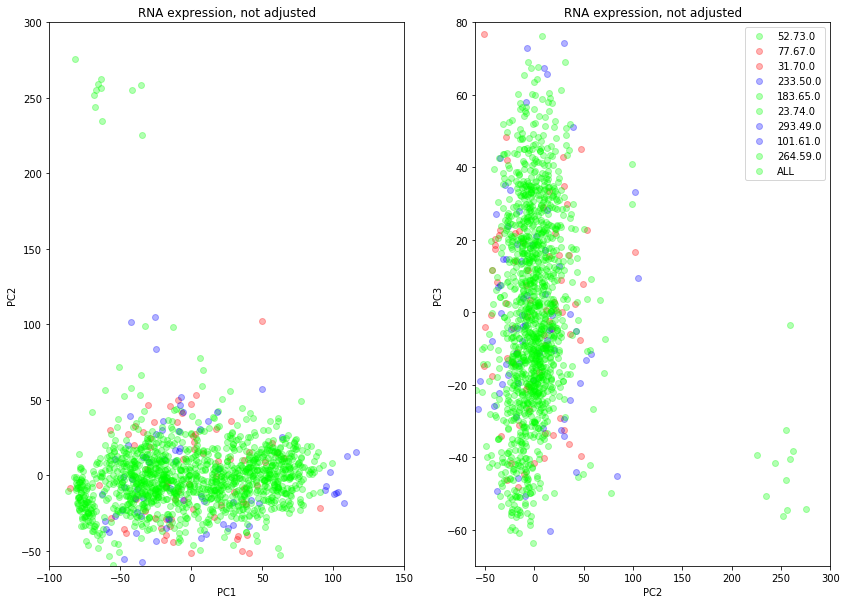

In [186]:
res_dict = merged_RNA_PCA
import random
def random_color():
    rgbl=[255,0,0]
    random.shuffle(rgbl)    
    return tuple([float(el)/255 for el in rgbl])

cohorts = res_dict.keys()
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
#rnd_sel = random.sample(cohorts, 10)
clr_list = []
for _cohort in rnd_sel:
    clr = random_color()
    clr_list.append(clr)
    ax[0].plot(res_dict[_cohort]['data'][:,0], 
             res_dict[_cohort]['data'][:,1], 'o', color=clr, alpha=0.3,label=_cohort)
    ax[1].plot(res_dict[_cohort]['data'][:,1], 
             res_dict[_cohort]['data'][:,2], 'o', color=clr, alpha=0.3,label=_cohort)    
    
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_xlim(-100,150)
ax[0].set_ylim(-60,300)
ax[1].set_xlabel('PC2')
ax[1].set_ylabel('PC3')
ax[1].set_xlim(-60,300)
ax[1].set_ylim(-70,80)

ax[0].set_title('RNA expression, not adjusted')
ax[1].set_title('RNA expression, not adjusted')
plt.legend()



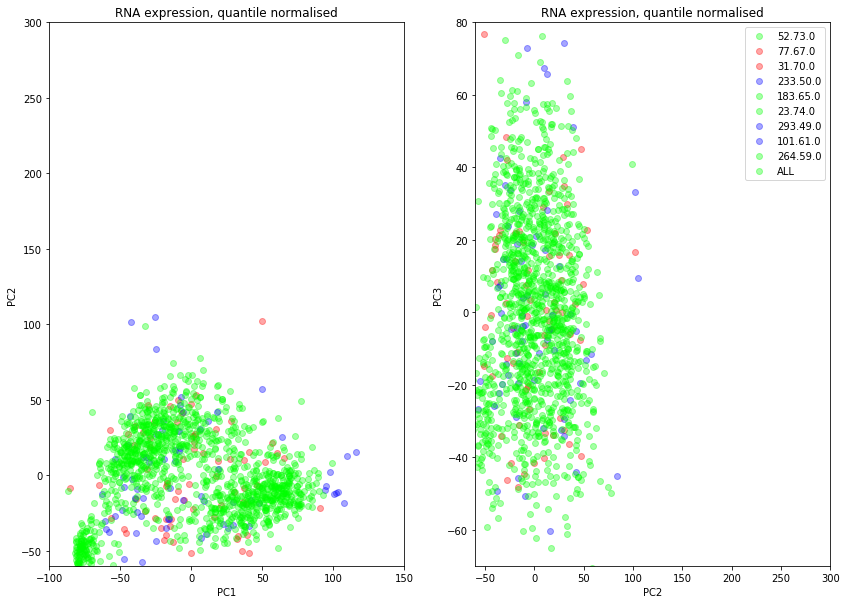

In [188]:
res_dict = merged_RNA_LS_PCA
import random
def random_color():
    rgbl=[255,0,0]
    random.shuffle(rgbl)    
    return tuple([float(el)/255 for el in rgbl])

cohorts = res_dict.keys()
fig, ax = plt.subplots(ncols=2, figsize=(14,10))
for idx, _cohort in enumerate(rnd_sel):
    clr = clr_list[idx] 
    ax[0].plot(res_dict[_cohort]['data'][:,0], 
             res_dict[_cohort]['data'][:,1], 'o', color=clr, alpha=0.35, label=_cohort)
    ax[1].plot(res_dict[_cohort]['data'][:,1], 
             res_dict[_cohort]['data'][:,2], 'o', color=clr, alpha=0.35, label=_cohort)    
    
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].set_xlim(-100,150)
ax[0].set_ylim(-60,300)

ax[1].set_xlabel('PC2')
ax[1].set_ylabel('PC3')
ax[1].set_xlim(-60,300)
ax[1].set_ylim(-70,80)

ax[0].set_title('RNA expression, quantile normalised')
ax[1].set_title('RNA expression, quantile normalised')
plt.legend()

In [91]:
def _multi_modality():
    # check for multi-modality: this effectively prevents the use of L/S for cohort-bias removal
    # create density kernel estimate a check for maxima.
    # https://towardsdatascience.com/modality-tests-and-kernel-density-estimations-3f349bb9e595
    # 1. Hartigan's diptest https://github.com/BenjaminDoran/unidip
    # 
    return True


def _cohort_bias_metrics_colwise(cohort_dict, one_vs_all = True, equi_size = False):
    '''
     cohort_dict: {cohort_name: {'data': PC's, 'reducer': PCA transformer}}
     one_vs_all: if True, compares each cohort to all other cohorts in bulk, 
                 else compares each cohort to each other cohort separately
    '''
    # Assumes reduction to 3 dimensions..
    # Because the cohorts have different sample sizes we cannot simply do an inter-cohort correlation
    # first we collect them in N columns, with N the number of PC's, then we cut those
    # vectors in M pieces where M is the average number of samples per cohort, then we perform the
    # correlation those artificial cohorts.
    # TO DO: add statistical significance tests..Kruskal-Wallis H Test, MW-U, FDR, KS
    metrics = {}
    cohorts = list(cohort_dict.keys())
    num_cohorts_ = len(cohorts) 
    if one_vs_all==False:
        # avg samples per cohort: M        
        
        if equi_size:
            pc1_matrix = cohort_dict[cohorts[0]]['data'][:,0]
            pc2_matrix = cohort_dict[cohorts[0]]['data'][:,1]
            pc3_matrix = cohort_dict[cohorts[0]]['data'][:,2]            
            for _cohort in cohorts[1:-1]:
                pc1_matrix = np.hstack((pc1_matrix, cohort_dict[_cohort]['data'][:,0]))
                pc2_matrix = np.hstack((pc2_matrix, cohort_dict[_cohort]['data'][:,1]))
                pc3_matrix = np.hstack((pc3_matrix, cohort_dict[_cohort]['data'][:,2]))
            
            len_ = pc1_matrix.shape[0]
            avg_samples = int(np.floor(len_/num_cohorts_))
            tot_num = avg_samples*len(cohorts)
            # cut in M pieces
            masked_ = np.random.randint(len_, size=(len_ - tot_num))
            pc1_matrix_ = np.delete(pc1_matrix, masked_) #np.ma.array(pc1_matrix, mask=False).mask[masked_].compressed()
            pc2_matrix_ = np.delete(pc2_matrix, masked_) #np.ma.array(pc2_matrix, mask=False).mask[masked_].compressed()
            pc3_matrix_ = np.delete(pc3_matrix, masked_) #np.ma.array(pc3_matrix, mask=False).mask[masked_].compressed()
            # reshape
            pc1_matrix_ = pc1_matrix_.reshape((avg_samples, num_cohorts_))
            pc2_matrix_ = pc2_matrix_.reshape((avg_samples, num_cohorts_))
            pc3_matrix_ = pc3_matrix_.reshape((avg_samples, num_cohorts_)) 
            
            pc_matrices = (pc1_matrix_, pc2_matrix_, pc3_matrix_)
                        
            # rank correlation, only works for equisized sets
            metrics['spearman']={}
            metrics['spearman'][0] = spearmanr(pc_matrices[0][:, :], pc_matrices[0][:, :])
            metrics['spearman'][1] = spearmanr(pc_matrices[1][:, :], pc_matrices[1][:, :])
            metrics['spearman'][2] = spearmanr(pc_matrices[2][:, :], pc_matrices[2][:, :])
            # Wasserstein-Distance 1st and 2nd, 
            metrics['wasserstein']={'1st': [np.zeros((num_cohorts_, num_cohorts_)), 
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))], 
                                    
                                    '2nd': [np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))]}   
            
            metrics['significance']={'MW-U': [np.zeros((num_cohorts_, num_cohorts_)), 
                                              np.zeros((num_cohorts_, num_cohorts_)),
                                              np.zeros((num_cohorts_, num_cohorts_))]}   
            for idx,pc_mat in enumerate(pc_matrices):
                for cohort_ind in range(0,num_cohorts_):    
                    for cohort_ind_sec in range(0,cohort_ind):
                        metrics['wasserstein']['1st'][idx][cohort_ind, cohort_ind_sec] = w1_dist(
                                                                          u_values=pc_mat[:, cohort_ind],
                                                                          v_values=pc_mat[:, cohort_ind_sec])
                        
                        metrics['wasserstein']['2nd'][idx][cohort_ind, cohort_ind_sec] = w2_dist(
                                                                          u_values=pc_mat[:, cohort_ind],
                                                                          v_values=pc_mat[:, cohort_ind_sec]) 

                        metrics['significance']['MW-U'][idx][cohort_ind, cohort_ind_sec] = mannwhitneyu(
                                                                          pc_mat[:, cohort_ind],
                                                                          pc_mat[:, cohort_ind_sec])[1]
        else: # non-equisized
            # wasserstein 1/2
            # log 10 of p-values of FDR of each cohort versus other cohorts (only for non-equisized cohorts)
            metrics['wasserstein']={'1st': [np.zeros((num_cohorts_, num_cohorts_)), 
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))], 
                                    
                                    '2nd': [np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_)),
                                            np.zeros((num_cohorts_, num_cohorts_))]}      

            metrics['significance']={'MW-U': [np.zeros((num_cohorts_, num_cohorts_)), 
                                              np.zeros((num_cohorts_, num_cohorts_)),
                                              np.zeros((num_cohorts_, num_cohorts_))] }
            for idx in range(0,3):
                for cohort_ind in range(0,num_cohorts_):    
                    for cohort_ind_sec in range(0,cohort_ind):
                        #print("cohort:",cohorts[cohort_ind], "idx:",idx)
                        metrics['wasserstein']['1st'][idx][cohort_ind, cohort_ind_sec] =\
                                    w1_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                            v_values=cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])  
                        
                        metrics['wasserstein']['2nd'][idx][cohort_ind, cohort_ind_sec] =\
                                    w2_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                            v_values=cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])
                        
                        metrics['significance']['MW-U'][idx][cohort_ind, cohort_ind_sec] =\
                                    mannwhitneyu(cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                                 cohort_dict[cohorts[cohort_ind_sec]]['data'][:, idx])[1]                        
                        
                        # FDR
                       
    else: # one-vs-all
        # for each cohort compare to the distributions of the rest
        # collect 
        pc1_matrix = cohort_dict[cohorts[0]]['data'][:,0]
        pc2_matrix = cohort_dict[cohorts[0]]['data'][:,1]
        pc3_matrix = cohort_dict[cohorts[0]]['data'][:,2]            
        for _cohort in cohorts[1:-1]:
            pc1_matrix = np.hstack((pc1_matrix, cohort_dict[_cohort]['data'][:,0]))
            pc2_matrix = np.hstack((pc2_matrix, cohort_dict[_cohort]['data'][:,1]))
            pc3_matrix = np.hstack((pc3_matrix, cohort_dict[_cohort]['data'][:,2]))
            
        pc_matrices = (pc1_matrix, pc2_matrix, pc3_matrix)

        metrics['wasserstein']={'1st': [np.zeros((num_cohorts_)), 
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))], 
                                    
                                '2nd': [np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))]}     
        metrics['significance']={'MW-U': [np.zeros((num_cohorts_)), 
                                        np.zeros((num_cohorts_)),
                                        np.zeros((num_cohorts_))] }
    
        for idx in range(0,3):
            for cohort_ind in range(0, num_cohorts_):
                metrics['wasserstein']['1st'][idx][cohort_ind]=\
                                w1_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                        v_values=pc_matrices[idx])
                    
                metrics['wasserstein']['2nd'][idx][cohort_ind] =\
                                w2_dist(u_values=cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                        v_values=pc_matrices[idx])
                
                metrics['significance']['MW-U'][idx][cohort_ind]=mannwhitneyu(
                                cohort_dict[cohorts[cohort_ind]]['data'][:, idx],
                                pc_matrices[idx])[1]
    return metrics


def _cohort_bias_metrics_rowwise(cohort_dict):
    '''
    Compare cohorts based on column-distributions per sample: without dimensionality reduction
    this allows for similarity measures, rank-correlations, as well as distribution comparators such 
    as the Wasserstein distance, statistical significance tests, rank-correlation and metric distance
    
    Per cohort take the mean of the feature values --> new vector (1, D) where D is the dimensionality
    Now compare these mean vectors using significance tests, rank-correlation and metrics distance     
    '''
    
    
    '''
    out: {cohort: Wasserstein (1/2), rank-correlation, metrics distance, Wilcoxon,..}
    '''
    return True


In [189]:
cohort_metrics_col_equiSize = _cohort_bias_metrics_colwise(cohort_dict=merged_RNA_PCA, equi_size=True, one_vs_all=False)
cohort_metrics_col_nonEquiSize = _cohort_bias_metrics_colwise(cohort_dict=merged_RNA_PCA, equi_size=False, one_vs_all=False)
cohort_metrics_col_oneVall = _cohort_bias_metrics_colwise(cohort_dict=merged_RNA_PCA, one_vs_all=True)

cohort_metrics_col_equiSize_LS = _cohort_bias_metrics_colwise(cohort_dict=merged_RNA_LS_PCA, equi_size=True, one_vs_all=False)
cohort_metrics_col_nonEquiSize_LS = _cohort_bias_metrics_colwise(cohort_dict=merged_RNA_LS_PCA, equi_size=False, one_vs_all=False)
cohort_metrics_col_oneVall_LS = _cohort_bias_metrics_colwise(cohort_dict=merged_RNA_LS_PCA, one_vs_all=True)

In [216]:
cohort_metrics_col_oneVall_LS['significance']['MW-U'][0].mean(axis=0)

0.3659507840673323

We expect that the distributions of the cohorts become more similar due to the cohort bias correction, hence the wasserstein distances become smaller and the p-values from FPR/ANOVA test reduce as well.

Text(0.5,1,'Variance explained for different Cohorts,not adjusted')

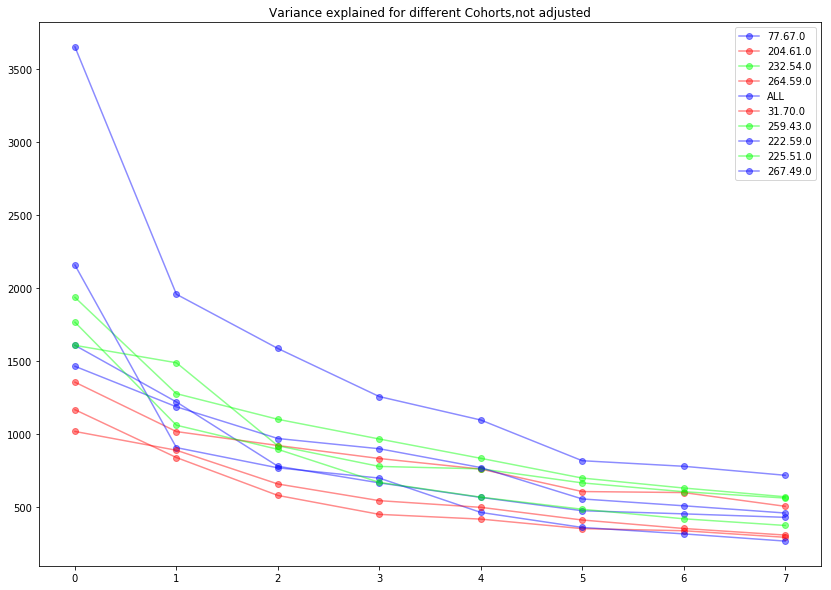

In [223]:
res_dict = merged_RNA_PCA
cohorts = res_dict.keys()
fig, ax = plt.subplots(ncols=1, figsize=(14,10))
rnd_sel = random.sample(cohorts,10)
clr_list = []
for _cohort in rnd_sel:
    clr = random_color()
    clr_list.append(clr)
    ax.plot(res_dict[_cohort]['reducer'].explained_variance_, 'o-', color=clr, alpha=0.45, label=_cohort)
ax.legend()
ax.set_title('Variance explained for different Cohorts,not adjusted')

Text(0.5,1,'Variance explained for different Cohorts, quantile normalised')

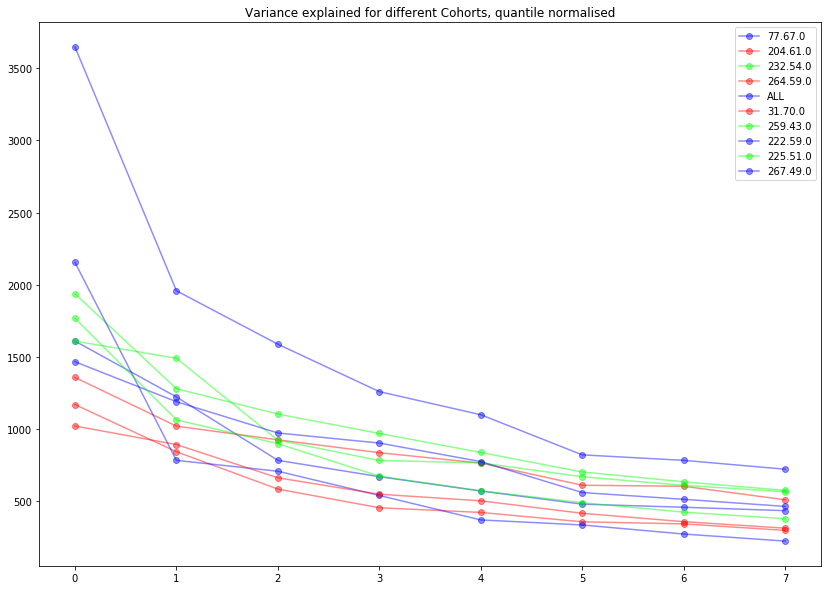

In [225]:
res_dict = merged_RNA_LS_PCA
cohorts = res_dict.keys()
fig, ax = plt.subplots(ncols=1, figsize=(14,10))
for idx, _cohort in enumerate(rnd_sel):
    clr = clr_list[idx]    
    ax.plot(res_dict[_cohort]['reducer'].explained_variance_, 'o-', color=clr, alpha=0.45, label=_cohort)
ax.legend()
ax.set_title('Variance explained for different Cohorts, quantile normalised')